
# Principal Components Analysis in Python for Engineers and Geoscientists 
### Michael Pyrcz, Associate Professor, University of Texas at Austin 

#### Contacts: [Twitter/@GeostatsGuy](https://twitter.com/geostatsguy) | [GitHub/GeostatsGuy](https://github.com/GeostatsGuy) | [www.michaelpyrcz.com](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446)

A tutorial/demonstration of **principal component analysis (PCA)**. For this demonstration we use a 1,000 well 7D unconventional dataset (file: unconv_MV.csv, with 6 predictors and 1 response) that may be found at https://github.com/GeostatsGuy/GeoDataSets. First, we take this multivariate dataset and only retain the two variables for a simple demonstration of PCA and then we work with all 6 predictors at once. I will use this tutorial in my Introduction to Geostatistics undergraduate class (PGE337 at UT Austin) as part of a first introduction to geostatistics and Python for the engineering undergraduate students. It is assumed that students have no previous Python nor geostatistics experience; therefore, all steps of the code and workflow are explored and described. This tutorial is augmented with course notes that will also be available at GitHub/GeostatsGuy.

#### Load the required libraries

In [ ]:
import os                                                 # to set current working directory 
from sklearn.decomposition import PCA                     # PCA program from scikit learn (package for machine learning)
from sklearn.preprocessing import StandardScaler          # standardize variables to mean of 0.0 and variance of 1.0
import pandas as pd                                       # DataFrames and plotting
import pandas.plotting as pd_plot
import numpy as np                                        # arrays and matrix math
import matplotlib.pyplot as plt                           # plotting

If you get a package import error, you may have to first install some of these packages. This can usually be accomplished by opening up a command window on Windows and then typing 'python -m pip install [package-name]'. More assistance is available with the respective package docs.  

#### Declare functions

Let's define a single function to streamline plotting correlation matrices. 

In [194]:
def plot_corr(dataframe,size=10):                         # plots a graphical correlation matrix 
    corr = dataframe.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    im = ax.matshow(corr,vmin = -1.0, vmax = 1.0)
    plt.xticks(range(len(corr.columns)), corr.columns);
    plt.yticks(range(len(corr.columns)), corr.columns);
    plt.colorbar(im, orientation = 'vertical')
    plt.title('Correlation Matrix')

#### Set the working directory

I always like to do this so I don't lose files and to simplify subsequent read and writes (avoid including the full address each time).


In [598]:
os.chdir("c:/PGE337/PCA")                                 # set the working directory

You will have to update the part in quotes with your own working directory and the format is different on a Mac (e.g. "~/PGE").  

#### Read the data table

First copy the "unconv_MV.csv" comma delimited file from https://github.com/GeostatsGuy/GeoDataSets to your working directory, then run this command to read the file into a DataFrame object (part of Pandas package).  

In [457]:
my_data = pd.read_csv("unconv_MV.csv")                    # load the comma delimited data file

Let's visualize the first several rows of our data stored in a DataFrame so we can make sure we successfully loaded the data file.

In [458]:
my_data[:7]                                               # preview the first 7 rows of the dataframe

,WellIndex,Por,LogPerm,AI,Brittle,TOC,VR,Production
0,1,15.91,1.67,3.06,14.05,1.36,1.85,177.381958
1,2,15.34,1.65,2.60,31.88,1.37,1.79,1479.767778
2,3,20.45,2.02,3.13,63.67,1.79,2.53,4421.221583
3,4,11.95,1.14,3.90,58.81,0.40,2.03,1488.317629
4,5,19.53,1.83,2.57,43.75,1.40,2.11,5261.094919
5,6,19.47,2.04,2.73,54.37,1.42,2.12,5497.005506
6,7,12.70,1.30,3.70,43.03,0.45,1.95,1784.266285


Let's remove the well index and check the summary summary statistics.

In [596]:
my_data = my_data.iloc[:,1:8]                             # copy all rows and columns 1 through 8, note 0 column is removed
my_data.describe().transpose()                            # calculate summary statistics for the data

,count,mean,std,min,25%,50%,75%,max
LogPerm,1000.0,1.398880,0.405966,0.120000,1.13000,1.39000,1.680000,2.58000
AI,1000.0,2.982610,0.577629,0.960000,2.57750,3.01000,3.360000,4.70000
Brittle,1000.0,49.731480,15.033593,0.000000,39.72250,49.68000,59.170000,93.47000
TOC,1000.0,1.006170,0.499838,0.000000,0.64000,0.99500,1.360000,2.71000
VR,1000.0,1.991170,0.308194,0.900000,1.81000,2.00000,2.172500,2.90000
Production,1000.0,2247.295809,1464.256312,2.713535,1191.36956,1976.48782,3023.594214,12568.64413


Good that we checked the summary statistics, we have some negative values for brittleness and total organic carbon. The is physically imposible.  The values must be in error. We know the lowest possible values are 0.0, so we will truncate on 0.0.  We use the *get_numerical_data()* DataFrame member function to get a shallow copy of the data from the DataFrame.  Since it is a shallow copy, any changes we make to the copy are made to the data in the original DataFrame.  This allows us to apply this simple conditional statement to all the data values in the DataFrame all at once.

In [597]:
num = my_data._get_numeric_data()                         # get the numerical values
num[num < 0] = 0                                          # truncate negative values to 0.0
my_data.describe().transpose()                            # calculate summary statistics for the data

,count,mean,std,min,25%,50%,75%,max
LogPerm,1000.0,1.398880,0.405966,0.120000,1.13000,1.39000,1.680000,2.58000
AI,1000.0,2.982610,0.577629,0.960000,2.57750,3.01000,3.360000,4.70000
Brittle,1000.0,49.731480,15.033593,0.000000,39.72250,49.68000,59.170000,93.47000
TOC,1000.0,1.006170,0.499838,0.000000,0.64000,0.99500,1.360000,2.71000
VR,1000.0,1.991170,0.308194,0.900000,1.81000,2.00000,2.172500,2.90000
Production,1000.0,2247.295809,1464.256312,2.713535,1191.36956,1976.48782,3023.594214,12568.64413


This dataset has variables from 1,000 unconventional wells including well average porosity, log transform of permeability (to linearize the relationships with other variables), accoustic impedance (kg/m2s*10^6), brittness ratio (%), total organic carbon (%), vitrinite reflectance (%), and initial production 90 day average (MCFPD).  Note, the dataset is synthetic.

#### Calculate the correlation matrix 

For multivariate analysis it is a good idea to check the correlation matrix.  We can calculate it and view it in the console with these commands.

In [461]:
corr_matrix = np.corrcoef(my_data, rowvar = False)
print(np.around(corr_matrix,2))                           # print the correlation matrix to 2 decimals

[[ 1.    0.81 -0.51 -0.25  0.71  0.08  0.69]
 [ 0.81  1.   -0.32 -0.15  0.51  0.05  0.57]
 [-0.51 -0.32  1.    0.17 -0.55  0.49 -0.33]
 [-0.25 -0.15  0.17  1.   -0.24  0.3  -0.07]
 [ 0.71  0.51 -0.55 -0.24  1.    0.31  0.5 ]
 [ 0.08  0.05  0.49  0.3   0.31  1.    0.14]
 [ 0.69  0.57 -0.33 -0.07  0.5   0.14  1.  ]]


Note the 1.0 diagonal resulting from the correlation of each variable with themselves.  

Let's use our function declared above to make a graphical correlation matrix visualization.  This may inprove our ability to spot features.  It relies on the built in correlation matrix method with Numpy DataFrames and MatPlotLib for plotting.

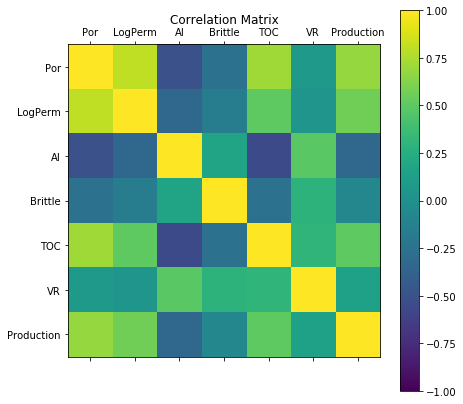

In [462]:
plot_corr(my_data,7)                                      # using our correlation matrix visualization function
plt.show()

This looks good.  There is a mix of bivariate, linear correlation magnitudes. Of course, correlation coeffficients are limited to degree of linear correlations.  For more complete information, let's look at the matrix scatter plot from the  Pandas package. 

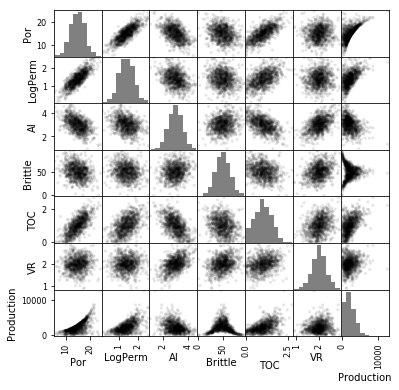

In [463]:
pd_plot.scatter_matrix(my_data, alpha = 0.1,              # pandas matrix scatter plot
    figsize=(6, 6),color = 'black', hist_kwds={'color':['grey']})
plt.show()

#### Simple Bivariate Example

Let's simplify the problem to bivariate (2 features), porosity and the log transform of permeability and reduce the number of wells from 1,000 to 100.

In [464]:
my_data_por_perm = my_data.iloc[0:100,0:2]                # extract just por and logperm, 100 samples
my_data_por_perm.describe().transpose()                   # calculate summary statistics for the data

,count,mean,std,min,25%,50%,75%,max
Por,100.0,14.9856,2.823016,9.23,12.9275,14.720,16.705,21.00
LogPerm,100.0,1.3947,0.390947,0.36,1.1475,1.365,1.650,2.48


Let's first check the univariate statistics of Por and LogPerm.

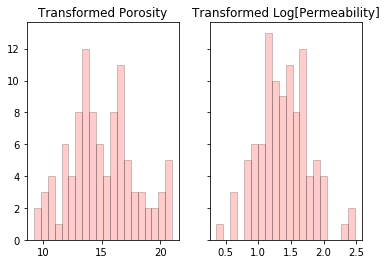

In [465]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.hist(my_data_por_perm["Por"], alpha = 0.2, color = 'red', edgecolor = 'black', bins=20)
ax1.set_title('Transformed Porosity')
ax2.hist(my_data_por_perm["LogPerm"], alpha = 0.2, color = 'red', edgecolor = 'black', bins=20)
ax2.set_title('Transformed Log[Permeability]')
plt.show()

The distributions may actually be Gaussian distributed, regardless they are well behaved, we cannot observe obvious gaps nor truncations.  Let's look at a scatter plot of porosity vs. log permeability.

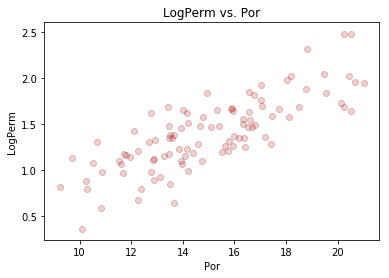

In [466]:
plt.scatter(my_data_por_perm["Por"],my_data_por_perm["LogPerm"],s=None, c="red", marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.2, linewidths=1.0, verts=None, edgecolors="black")
plt.title('LogPerm vs. Por'); plt.xlabel('Por'); plt.ylabel('LogPerm')
plt.show()

#### Calculation of Principal Components

With the log of permeability we have a very nice linear relationship with porosity, PCA should work well on this data.  We are ready to perform PCA with porosity and log of permeability. The

We must standardize our variables to have a mean equal to zero, $\bar{x} = 0.0$, and the variance equal to one, $\sigma^{2}_{x} = 1.0$.  Otherwise the difference between the scale of porosity and permeability would have a significant impact. This is quite arbitrary!  What if we convert the logperm feature from log of milliDacry to log of Darcy? or change the porosity to a fraction instead of a percentage?  To remove this effect, we should always standardize unless the two variables have the same units and then the range, variance between them is meaningful.

In [500]:
from sklearn.preprocessing import StandardScaler

features = ['Por','LogPerm']
x = my_data_por_perm.loc[:,features].values
mu = np.mean(x, axis=0)
sd = np.std(x, axis=0)
x = StandardScaler().fit_transform(x)                     # standardize the data features to mean = 0, var = 1.0

print("Original Mean Por", np.round(mu[0],2), ', Original Mean LogPerm = ', np.round(mu[1],2)) 
print("Original StDev Por", np.round(sd[0],2), ', Original StDev LogPerm = ', np.round(sd[1],2)) 
print('Mean Transformed Por =',np.round(np.mean(x[:,0]),2),', Mean Transformed LogPerm =',np.round(np.mean(x[:,1]),2))
print('Variance Transformed Por =',np.var(x[:,0]),', Variance Transformed LogPerm =',np.var(x[:,1]))

Original Mean Por 14.99 , Original Mean LogPerm =  1.39
Original StDev Por 2.81 , Original StDev LogPerm =  0.39
Mean Transformed Por = 0.0 , Mean Transformed LogPerm = -0.0
Variance Transformed Por = 1.0 , Variance Transformed LogPerm = 1.0


"x" is a 2D ndarray from Numpy package with the features in columns and the samples in rows.  Above we comfirmed that the features in the "x" 2D array are infact standardized. It is not a bad idea to check the univariate and bivariate distributions of our standardized variables.

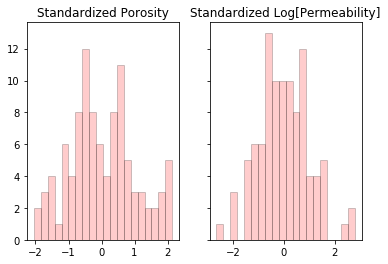

In [470]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.hist(x[:,0], alpha = 0.2, color = 'red', edgecolor = 'black', bins=20)
ax1.set_title('Standardized Porosity')
ax2.hist(x[:,1], alpha = 0.2, color = 'red', edgecolor = 'black', bins=20)
ax2.set_title('Standardized Log[Permeability]')
plt.show()

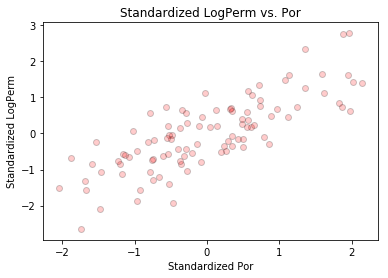

In [471]:
plt.scatter(x[:,0],x[:,1], s=None, c="red", marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.2, linewidths=1.0, verts=None, edgecolors="black")
plt.title('Standardized LogPerm vs. Por'); plt.xlabel('Standardized Por'); plt.ylabel('Standardized LogPerm')
plt.show()

Everything looks fine and we are ready to apply principal components analysis.

#### Principal Component Analysis (PCA)

To run PCA with the SciKitLearn machine learning package in Python, we first make a PCA model with a specified number of components and then we 'fit' it to our data. As you will see later with dimensional reduction, we can use matrix math with this model and reduce our data to any dimensionality from 1 to the number of features. Let's run the model with number of components equal to number of features.

In [488]:
n_components = 2
pca = PCA(n_components=n_components)
pca.fit(x)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

The first thing we sould do is look at the component loadings.  Let's view them and interpret our result.

In [489]:
print(np.round(pca.components_,3))

[[ 0.707  0.707]
 [ 0.707 -0.707]]


Interesting, after standardization, both variables have the same level of influence on each principle component.If one feature had a greater inpact on the first principle component then we could say it was more important to describe variance in the data.  It is also important to look at the proportion of the variance described by each principal component.

In [490]:
print('Variance explained by PC1 and PC2 =', np.round(pca.explained_variance_ratio_,3))

Variance explained by PC1 and PC2 = [ 0.896  0.104]


We can calculate the principle component scores of the original data. This is effectly a rotation of the data,  aligned with PC1 for the direction of greatest variance.  We will calculate the principal component scores with the "transform" function built into PCA and then visualize as a scatter plot. The to "close the loop" and check what we have done (and our knowledge) we will reverse the PCA, go from the principal component scores back to the standardized features.

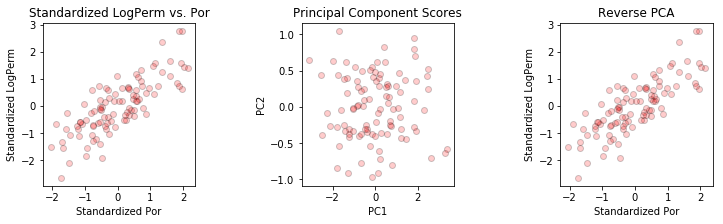

In [495]:
f, (ax101, ax102, ax103) = plt.subplots(1, 3,figsize=(12,3))
f.subplots_adjust(wspace=0.7)

ax101.scatter(x[:,0],x[:,1], s=None, c="red", marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.2, linewidths=1.0, verts=None, edgecolors="black")
ax101.set_title('Standardized LogPerm vs. Por'); ax101.set_xlabel('Standardized Por'); ax101.set_ylabel('Standardized LogPerm')

x_trans = pca.transform(x)                                # calculate the principal component scores
ax102.scatter(x_trans[:,0],x_trans[:,1],s=None, c="red", marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.2, linewidths=1.0, verts=None, edgecolors="black")
ax102.set_title('Principal Component Scores'); ax102.set_xlabel('PC1'); ax102.set_ylabel('PC2')

x_reverse = pca.transform(x_trans)                        # reverse the principal component scores to standardized values
ax103.scatter(x_reverse[:,0],x_reverse[:,1],s=None, c="red", marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.2, linewidths=1.0, verts=None, edgecolors="black")
ax103.set_title('Reverse PCA'); ax103.set_xlabel('Standardized Por'); ax103.set_ylabel('Standardized LogPerm')
plt.show()

The two cross plots should look exactly the same. If so, the method is working.

#### Demostration of Dimensional Reduction

Now let's attempt **dimensional reduction** by only retaining the first principle component.  We will go from original values to predictions of original values. Recall we were able to explain about 90% of the variance with the first principal component so the result should look 'pretty good', right?  We will do the whole thing by hand to make it as simple/understandable as possible for this first time through.  Later we will be much more compact.  The steps: 

1. start with the original porosity and permeability data 
2. standardize such that Por and LogPerm have a mean of 0.0 and a variance of 1.0
3. calculate the 2 principal component model, visualize the principal component scores
4. remove the 2nd principal component by setting the associated component scores to 0.0
5. reverse the principal component by matrix multiplication of the scores with the component loadings
6. apply matrix math to restore the original mean and variance

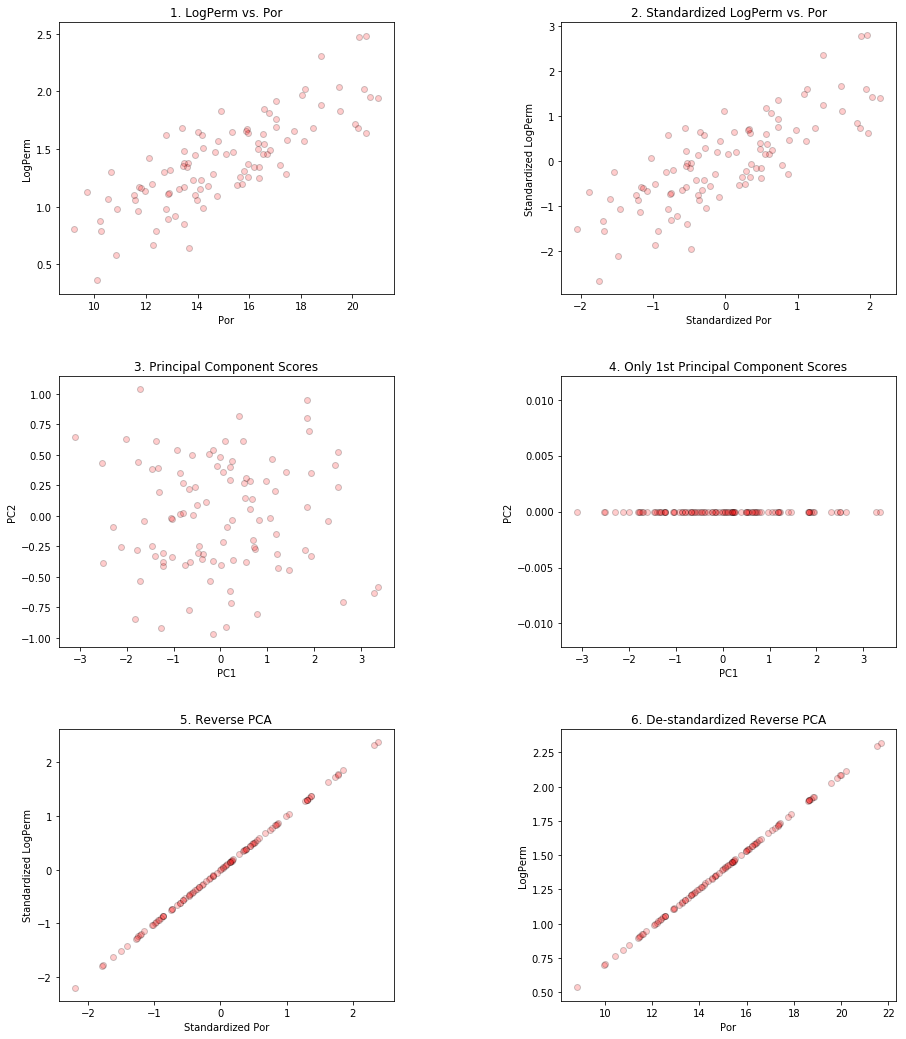

In [526]:

f, ((ax201, ax202), (ax203, ax204), (ax205, ax206)) = plt.subplots(3, 2,figsize=(15,18))
f.subplots_adjust(wspace=0.5,hspace = 0.3)

ax201.scatter(my_data_por_perm["Por"],my_data_por_perm["LogPerm"],s=None, c="red", marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.2, linewidths=1.0, verts=None, edgecolors="black")
ax201.set_title('1. LogPerm vs. Por'); ax201.set_xlabel('Por'); ax201.set_ylabel('LogPerm')

x = my_data_por_perm.loc[:,features].values
mu = np.mean(x, axis=0)
sd = np.std(x, axis=0)
x = StandardScaler().fit_transform(x)                     # standardize the data features to mean = 0, var = 1.0

ax202.scatter(x[:,0],x[:,1], s=None, c="red", marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.2, linewidths=1.0, verts=None, edgecolors="black")
ax202.set_title('2. Standardized LogPerm vs. Por'); ax202.set_xlabel('Standardized Por'); ax202.set_ylabel('Standardized LogPerm')

n_components = 2                                          # build principal component model with 2 components
pca = PCA(n_components=n_components)
pca.fit(x)

x_trans = pca.transform(x)                                # calculate principal component scores
ax203.scatter(x_trans[:,0],x_trans[:,1],s=None, c="red", marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.2, linewidths=1.0, verts=None, edgecolors="black")
ax203.set_title('3. Principal Component Scores'); ax203.set_xlabel('PC1'); ax203.set_ylabel('PC2')

x_trans[:,1] = 0.0                                         # zero / remove the 2nd principal component 

ax204.scatter(x_trans[:,0],x_trans[:,1],s=None, c="red", marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.2, linewidths=1.0, verts=None, edgecolors="black")
ax204.set_title('4. Only 1st Principal Component Scores'); ax204.set_xlabel('PC1'); ax204.set_ylabel('PC2')

xhat = pca.transform(x_trans)                             # reverse the principal component scores to standardized values
ax205.scatter(xhat[:,0],xhat[:,1],s=None, c="red", marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.2, linewidths=1.0, verts=None, edgecolors="black")
ax205.set_title('5. Reverse PCA'); ax205.set_xlabel('Standardized Por'); ax205.set_ylabel('Standardized LogPerm')

xhat = np.dot(pca.transform(x)[:,:nComp], pca.components_[:nComp,:])
xhat = sd*xhat + mu                                       # remove the standardization

ax206.scatter(xhat[:,0],xhat[:,1],s=None, c="red", marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.2, linewidths=1.0, verts=None, edgecolors="black")
ax206.set_title('6. De-standardized Reverse PCA'); ax206.set_xlabel('Por'); ax206.set_ylabel('LogPerm')

plt.show()

Let's put the original data and the resulting lower dimensional model side-by-side and check the resulting variances.

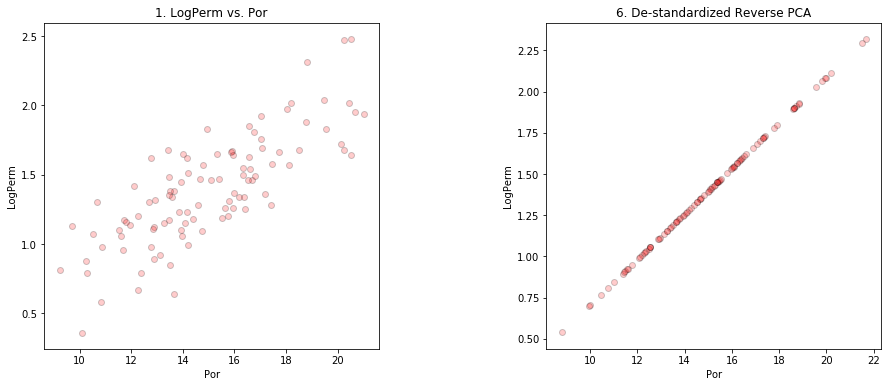

Variance Por = 7.89 , Variance Reduced Dimensional Por = 7.073 Fraction =  0.896
Variance LogPerm = 7.89 , Variance Reduced Dimensional LogPerm = 0.136 Fraction =  0.896


In [543]:
f, (ax201, ax206) = plt.subplots(1, 2,figsize=(15,6))
f.subplots_adjust(wspace=0.5,hspace = 0.3)

ax201.scatter(my_data_por_perm["Por"],my_data_por_perm["LogPerm"],s=None, c="red", marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.2, linewidths=1.0, verts=None, edgecolors="black")
ax201.set_title('1. LogPerm vs. Por'); ax201.set_xlabel('Por'); ax201.set_ylabel('LogPerm')

ax206.scatter(xhat[:,0],xhat[:,1],s=None, c="red", marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.2, linewidths=1.0, verts=None, edgecolors="black")
ax206.set_title('6. De-standardized Reverse PCA'); ax206.set_xlabel('Por'); ax206.set_ylabel('LogPerm')
plt.show()

var_por = np.var(my_data_por_perm["Por"]); var_por_hat = np.var(xhat[:,0]);
var_logperm = np.var(my_data_por_perm["LogPerm"]); var_logperm_hat = np.var(xhat[:,1]);
print('Variance Por =',np.round(var_por,3),', Variance Reduced Dimensional Por =',np.round(var_por_hat,3),'Fraction = ',np.round(var_por_hat/var_por,3))
print('Variance LogPerm =',np.round(var_por,3),', Variance Reduced Dimensional LogPerm =',np.round(var_logperm_hat,3),'Fraction = ',np.round(var_logperm_hat/var_logperm,3))


We got a model that explains 89.6% of the variance for both porosity and lob permeability.

#### Return to the original 6 predictors / features

We will go back to the original data file and this time extract all 6 predictor variables and the first 500 samples.  

In [556]:
my_data_f6 = my_data.iloc[0:500,0:6]                      # extract the 6 predictors, 500 samples

It is a good idea to start with the summary statistics for our data.

In [557]:
my_data_f6.describe().transpose()                         # calculate summary statistics for the data

,count,mean,std,min,25%,50%,75%,max
Por,500.0,14.89936,2.985967,5.40,12.8500,14.900,17.0125,23.85
LogPerm,500.0,1.40010,0.409616,0.18,1.1475,1.380,1.6700,2.58
AI,500.0,2.99244,0.563674,1.21,2.5900,3.035,3.3725,4.70
Brittle,500.0,49.74682,15.212123,0.00,39.3125,49.595,59.2075,93.47
TOC,500.0,0.99800,0.503635,0.00,0.6400,0.960,1.3500,2.71
VR,500.0,1.99260,0.307434,0.90,1.8200,2.010,2.1725,2.84


Let's also calculate a correlation matrix and view it. 

In [558]:
corr_matrix = np.corrcoef(my_data_f6, rowvar = False)
print(np.around(corr_matrix,2))                           # print the correlation matrix to 2 decimals

[[ 1.    0.79 -0.49 -0.25  0.71  0.12]
 [ 0.79  1.   -0.32 -0.13  0.48  0.04]
 [-0.49 -0.32  1.    0.14 -0.53  0.47]
 [-0.25 -0.13  0.14  1.   -0.24  0.24]
 [ 0.71  0.48 -0.53 -0.24  1.    0.35]
 [ 0.12  0.04  0.47  0.24  0.35  1.  ]]


We will need to standardize each variable to have a mean of zero and a variance of one.  Let's do that and check the results. In the console below we print all the initial and standardized means and variances for all 6 predictors. 

In [559]:
from sklearn.preprocessing import StandardScaler

features = ['Por','LogPerm','AI','Brittle','TOC','VR']
x_f6 = my_data_f6.loc[:,features].values
mu_f6 = np.mean(x_f6, axis=0)
sd_f6 = np.std(x_f6, axis=0)
x_f6 = StandardScaler().fit_transform(x_f6)
 
print("Original Means", features[:], np.round(mu_f6[:],2)) 
print("Original StDevs", features[:],np.round(sd_f6[:],2)) 
print('Mean Transformed =',features[:],np.round(x.mean(axis=0),2))
print('Variance Transformed Por =',features[:],np.round(x.var(axis=0),2))

Original Means ['Por', 'LogPerm', 'AI', 'Brittle', 'TOC', 'VR'] [ 14.9    1.4    2.99  49.75   1.     1.99]
Original StDevs ['Por', 'LogPerm', 'AI', 'Brittle', 'TOC', 'VR'] [  2.98   0.41   0.56  15.2    0.5    0.31]
Mean Transformed = ['Por', 'LogPerm', 'AI', 'Brittle', 'TOC', 'VR'] [ 0. -0.]
Variance Transformed Por = ['Por', 'LogPerm', 'AI', 'Brittle', 'TOC', 'VR'] [ 1.  1.]


We whould also check the univariate distributions for each variable.

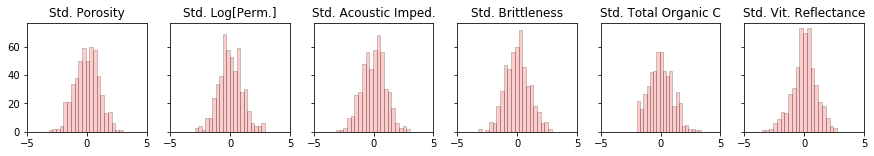

In [560]:
f, (ax6,ax7,ax8,ax9,ax10,ax11) = plt.subplots(1, 6, sharey=True, figsize=(15,2))
ax6.hist(x_f6[:,0], alpha = 0.2, color = 'red', edgecolor = 'black', bins=20); ax6.set_title('Std. Porosity'); ax6.set_xlim(-5,5)
ax7.hist(x_f6[:,1], alpha = 0.2, color = 'red', edgecolor = 'black', bins=20); ax7.set_title('Std. Log[Perm.]'); ax7.set_xlim(-5,5)
ax8.hist(x_f6[:,2], alpha = 0.2, color = 'red', edgecolor = 'black', bins=20); ax8.set_title('Std. Acoustic Imped.'); ax8.set_xlim(-5,5)
ax9.hist(x_f6[:,3], alpha = 0.2, color = 'red', edgecolor = 'black', bins=20); ax9.set_title('Std. Brittleness'); ax9.set_xlim(-5,5)
ax10.hist(x_f6[:,4], alpha = 0.2, color = 'red', edgecolor = 'black', bins=20); ax10.set_title('Std. Total Organic C'); ax10.set_xlim(-5,5)
ax11.hist(x_f6[:,5], alpha = 0.2, color = 'red', edgecolor = 'black', bins=20); ax11.set_title('Std. Vit. Reflectance'); ax11.set_xlim(-5,5)
plt.show()

The summary statistics and distributions look good.  No obvious missing data, gaps, significant truncations, spikes or outliers.  We are ready to peform principal component analysis on our 6 features.

In [568]:
# Principal Component Analysis

n_components = 6
pca_f6 = PCA(n_components=n_components)
pca_f6.fit(x_f6)

print(np.round(pca_f6.components_,3))                     # visualize the component loadings

[[ 0.558  0.476 -0.405 -0.211  0.504  0.01 ]
 [-0.117 -0.114 -0.432 -0.323 -0.229 -0.794]
 [-0.019 -0.124  0.384 -0.898  0.07   0.157]
 [-0.214 -0.674 -0.424 -0.006  0.526  0.21 ]
 [-0.784  0.522 -0.031 -0.046  0.331 -0.019]
 [ 0.12  -0.138  0.566  0.206  0.55  -0.549]]


Let's look at the component loadings first.  Each row is a component, top row is the first principal component (PC1), next row is the second principal component (PC2) up to the last row the sixth principal component (PC6).  The columns are the features ordered from 'Por', 'LogPerm', 'AI', 'Brittle', 'TOC', to 'VR'.

First principal component is mainly composed of porosity, log permeability, acoustic impedanced and total organic carbon, suggesting that the way they vary together is responsible for much of the variance.  The next principle component is mainly composed of vitrinite reflectance.  The third principal coordinate is mainly composed of brittleness and so on.

To assist in this interpretation we should consider the variance contributions from each principal component.

In [569]:
print('Variance explained by PC1 thru PC6 =', np.round(pca_f6.explained_variance_ratio_,3))

Variance explained by PC1 thru PC6 = [ 0.462  0.246  0.149  0.11   0.024  0.009]


We can see that about 46% of the variance is described by the 1st principal component and then about 25% is described by the 2nd principal component etc.  It would be interesting to look just at the porosity vs. log permeability bivariate relationship when we retain $1,\ldots,6$ principal components.  To do this we use matrix math to reverse with PCA and the standardization with various number of principal component and then plot the scattter plots of log permeability vs. porosity.

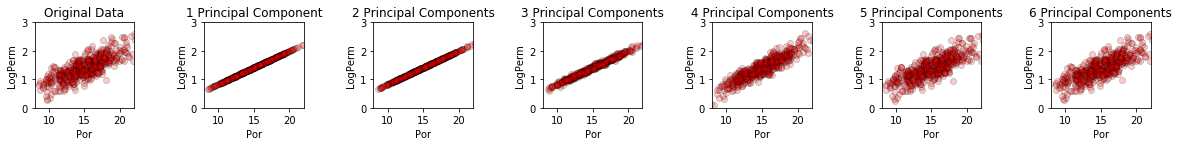

In [575]:
nComp = 6
xhat_6d = np.dot(pca_f6.transform(x_f6)[:,:nComp], pca_f6.components_[:nComp,:])
xhat_6d = sd_f6*xhat_6d + mu_f6

nComp = 5
xhat_5d = np.dot(pca_f6.transform(x_f6)[:,:nComp], pca_f6.components_[:nComp,:])
xhat_5d = sd_f6*xhat_5d + mu_f6

nComp = 4
xhat_4d = np.dot(pca_f6.transform(x_f6)[:,:nComp], pca_f6.components_[:nComp,:])
xhat_4d = sd_f6*xhat_4d + mu_f6

nComp = 3
xhat_3d = np.dot(pca_f6.transform(x_f6)[:,:nComp], pca_f6.components_[:nComp,:])
xhat_3d = sd_f6*xhat_3d + mu_f6

nComp = 2
xhat_2d = np.dot(pca_f6.transform(x_f6)[:,:nComp], pca_f6.components_[:nComp,:])
xhat_2d = sd_f6*xhat_2d + mu_f6

nComp = 1
xhat_1d = np.dot(pca_f6.transform(x_f6)[:,:nComp], pca_f6.components_[:nComp,:])
xhat_1d = sd_f6*xhat_1d + mu_f6

f, (ax12, ax13, ax14, ax15, ax16, ax17, ax18) = plt.subplots(1, 7,figsize=(20,20))
f.subplots_adjust(wspace=0.7)

ax12.scatter(my_data_f6["Por"],my_data_f6["LogPerm"],s=None, c="red",marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.2, linewidths=1.0, verts=None, edgecolors="black")
ax12.set_title('Original Data'); ax12.set_xlabel('Por'); ax12.set_ylabel('LogPerm')
ax12.set_ylim(0.0,3.0); ax12.set_xlim(8,22); ax12.set_aspect(4.0); 

ax13.scatter(xhat_1d[:,0],xhat_1d[:,1],s=None, c="red", marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.2, linewidths=1.0, verts=None, edgecolors="black")
ax13.set_title('1 Principal Component'); ax13.set_xlabel('Por'); ax13.set_ylabel('LogPerm')
ax13.set_ylim(0.0,3.0); ax13.set_xlim(8,22); ax13.set_aspect(4.0)

ax14.scatter(xhat_2d[:,0],xhat_2d[:,1],s=None, c="red", marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.2, linewidths=1.0, verts=None, edgecolors="black")
ax14.set_title('2 Principal Components'); ax14.set_xlabel('Por'); ax14.set_ylabel('LogPerm')
ax14.set_ylim(0.0,3.0); ax14.set_xlim(8,22); ax14.set_aspect(4.0)

ax15.scatter(xhat_3d[:,0],xhat_3d[:,1],s=None, c="red", marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.2, linewidths=1.0, verts=None, edgecolors="black")
ax15.set_title('3 Principal Components'); ax15.set_xlabel('Por'); ax15.set_ylabel('LogPerm')
ax15.set_ylim(0.0,3.0); ax15.set_xlim(8,22); ax15.set_aspect(4.0)

ax16.scatter(xhat_4d[:,0],xhat_4d[:,1],s=None, c="red", marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.2, linewidths=1.0, verts=None, edgecolors="black")
ax16.set_title('4 Principal Components'); ax16.set_xlabel('Por'); ax16.set_ylabel('LogPerm')
ax16.set_ylim(0.0,3.0); ax16.set_xlim(8,22); ax16.set_aspect(4.0)

ax17.scatter(xhat_5d[:,0],xhat_5d[:,1],s=None, c="red", marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.2, linewidths=1.0, verts=None, edgecolors="black")
ax17.set_title('5 Principal Components'); ax17.set_xlabel('Por'); ax17.set_ylabel('LogPerm')
ax17.set_ylim(0.0,3.0); ax17.set_xlim(8,22); ax17.set_aspect(4.0)

ax18.scatter(xhat_6d[:,0],xhat_6d[:,1],s=None, c="red", marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.2, linewidths=1.0, verts=None, edgecolors="black")
ax18.set_title('6 Principal Components'); ax18.set_xlabel('Por'); ax18.set_ylabel('LogPerm')
ax18.set_ylim(0.0,3.0); ax18.set_xlim(8,22); ax18.set_aspect(4.0)

plt.show()

Very interesting to watch the accuracy of the bivariate relationship between log permeability and porosity imporve as we include more components.  Let's check the variances.  


In [590]:
print('1 Principal Component : Variance Por =',np.round(np.var(xhat_1d[:,0])/(sd_f6[0]*sd_f6[0]),2),' Variance Log Perm = ',np.round(np.var(xhat_1d[:,1])/(sd_f6[1]*sd_f6[1]),2))

print('2 Principal Components: Variance Por =',np.round(np.var(xhat_2d[:,0])/(sd_f6[0]*sd_f6[0]),2),' Variance Log Perm = ',np.round(np.var(xhat_2d[:,1])/(sd_f6[1]*sd_f6[1]),2))

print('3 Principal Components: Variance Por =',np.round(np.var(xhat_3d[:,0])/(sd_f6[0]*sd_f6[0]),2),' Variance Log Perm = ',np.round(np.var(xhat_3d[:,1])/(sd_f6[1]*sd_f6[1]),2))

print('4 Principal Components: Variance Por =',np.round(np.var(xhat_4d[:,0])/(sd_f6[0]*sd_f6[0]),2),' Variance Log Perm = ',np.round(np.var(xhat_4d[:,1])/(sd_f6[1]*sd_f6[1]),2))

print('5 Principal Components: Variance Por =',np.round(np.var(xhat_5d[:,0])/(sd_f6[0]*sd_f6[0]),2),'  Variance Log Perm = ',np.round(np.var(xhat_5d[:,1])/(sd_f6[1]*sd_f6[1]),2))

print('6 Principal Components: Variance Por =',np.round(np.var(xhat_6d[:,0])/(sd_f6[0]*sd_f6[0]),2),'  Variance Log Perm = ',np.round(np.var(xhat_6d[:,1])/(sd_f6[1]*sd_f6[1]),2))



1 Principal Component : Variance Por = 0.86  Variance Log Perm =  0.63
2 Principal Components: Variance Por = 0.88  Variance Log Perm =  0.65
3 Principal Components: Variance Por = 0.88  Variance Log Perm =  0.66
4 Principal Components: Variance Por = 0.91  Variance Log Perm =  0.96
5 Principal Components: Variance Por = 1.0   Variance Log Perm =  1.0
6 Principal Components: Variance Por = 1.0   Variance Log Perm =  1.0


This is interesting.  With the first principal component we decribe 86% of the porosity variance.  The next two principal components do not provide much assistance. Then there is a jump with the 4th and 5th principal components.  Of course, the problem is 6 dimensional, not just porosity vs. log permeability.  Let's look at the matrix scatter plots for see all of the bivariate combinations.

First some book keeping, we have to put the 6D reduced dimensionality models in DataFrames (there are currently Numpy ndarrays.

In [448]:
df_1d = pd.DataFrame(data=xhat_1d,columns=features)   
df_2d = pd.DataFrame(data=xhat_2d,columns=features)
df_3d = pd.DataFrame(data=xhat_3d,columns=features)
df_4d = pd.DataFrame(data=xhat_4d,columns=features)
df_5d = pd.DataFrame(data=xhat_5d,columns=features)
df_6d = pd.DataFrame(data=xhat_6d,columns=features)

Now we can go ahead and produce the matrix scatter plots with these DataFrames. It is very interesting to see the accuracy of the bivariate plots improve as we add principal components.  Also, with only two principal components we capture some of the bivariate relationships quite well for some of the variable pairs.

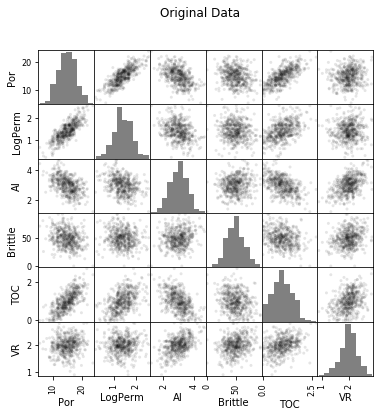

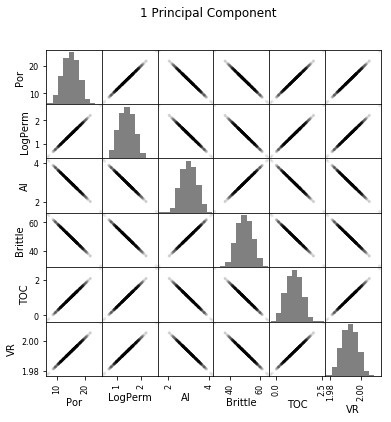

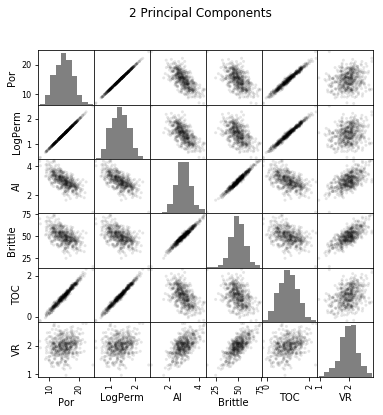

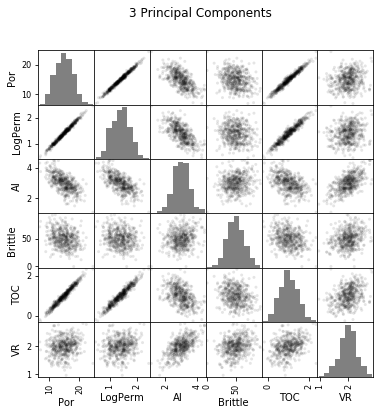

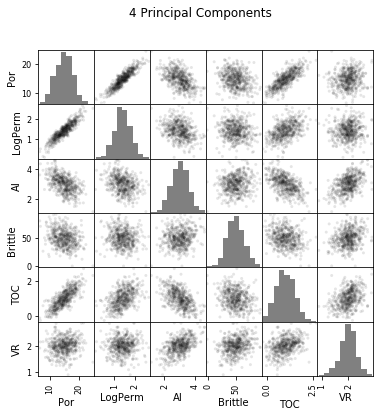

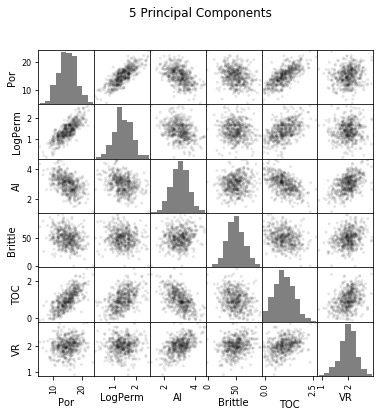

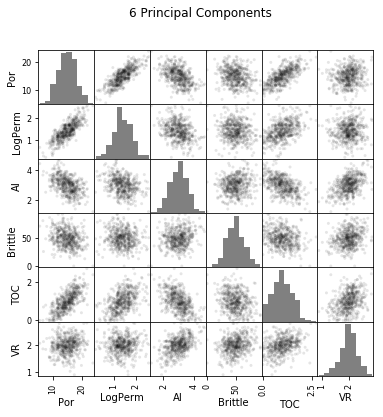

In [599]:
fig = plt.figure()

pd_plot.scatter_matrix(my_data_f6, alpha = 0.1,           # pandas matrix scatter plot
    figsize=(6, 6),color = 'black', hist_kwds={'color':['grey']})
plt.suptitle('Original Data')

pd_plot.scatter_matrix(df_1d, alpha = 0.1,                # pandas matrix scatter plot
    figsize=(6, 6),color = 'black', hist_kwds={'color':['grey']})
plt.suptitle('1 Principal Component')

pd_plot.scatter_matrix(df_2d, alpha = 0.1,                # pandas matrix scatter plot
    figsize=(6, 6),color = 'black', hist_kwds={'color':['grey']})
plt.suptitle('2 Principal Components')

pd_plot.scatter_matrix(df_3d, alpha = 0.1,                # pandas matrix scatter plot
    figsize=(6, 6),color = 'black', hist_kwds={'color':['grey']})
plt.suptitle('3 Principal Components')

pd_plot.scatter_matrix(df_4d, alpha = 0.1,                # pandas matrix scatter plot
    figsize=(6, 6),color = 'black', hist_kwds={'color':['grey']})
plt.suptitle('4 Principal Components')

pd_plot.scatter_matrix(df_5d, alpha = 0.1,                # pandas matrix scatter plot
    figsize=(6, 6),color = 'black', hist_kwds={'color':['grey']})
plt.suptitle('5 Principal Components')

pd_plot.scatter_matrix(df_6d, alpha = 0.1,                # pandas matrix scatter plot
    figsize=(6, 6),color = 'black', hist_kwds={'color':['grey']})
plt.suptitle('6 Principal Components')

plt.show()


There are so many more tests that one could attempt to gain experience with principal components analysis. I'll end here for brevity, but I invite you to continue. Consider, on your own apply other data sets or attempting methods with PCA kernels or regression.  I hope you found this tutorial useful. I'm always happy to discuss geostatistics, statistical modeling, uncertainty modeling and machine learning,

*Michael*

![](c:/PGE337/mjp_signature.png)


Michael Pyrcz, Ph.D., P.Eng. Associate Professor The Hildebrand Department of Petroleum and Geosystems Engineering The University of Texas at Austin